In [2]:
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt




In [3]:

#initialise the blackjack environment
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:

#display observation and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)


In [5]:
#define a custom policy for decision-making
def custom_policy(state):
    #fetch the player's hand value
    player_total = state[0]

    #decide to stand (0) if total is 19 or above, otherwise request card (1)
    if player_total >= 19:
        return 0  #stand
    else:
        return 1  #request card

In [6]:
#function to play multiple games
def play_blackjack(env, policy, games=5):
    results = []  #store results of all games
    for game in range(games):
        #reset the game
        state = env.reset()
        game_log = []  #log states, actions, and rewards for this game

        print(f'Game {game + 1} starts!')

        while True:
            action = policy(state)  #decide the action based on policy
            next_state, reward, done, _ = env.step(action)  #take a step in the environment
            game_log.append((state, action, reward))  #log the step
            state = next_state  #update to the new state

            #check if the game is over
            if done:
                print(f'Game {game + 1} ends! Outcome: {reward}')
                results.append({'reward': reward, 'log': game_log})  #save the game outcome
                break
    return results


In [7]:
#monte carlo prediction to estimate the action-value function
def monte_carlo_prediction(env, policy, episodes, gamma=1.0):
    #initialise dictionaries to track returns and counts
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    #iterate over multiple episodes
    for episode_idx in range(1, episodes + 1):
        if episode_idx % 500 == 0:
            print(f'Episode {episode_idx}/{episodes}')

        #generate a single episode
        state = env.reset()
        episode = []
        while True:
            action = policy(state)  #select action based on policy
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))  #log the episode
            state = next_state
            if done:
                break

        #process the episode for returns and Q updates
        visited = set()
        for idx, (state, action, reward) in enumerate(episode):
            if (state, action) not in visited:
                visited.add((state, action))
                #calculate the return
                G = sum(gamma**i * episode[i][2] for i in range(idx, len(episode)))
                returns_sum[state][action] += G  #accumulate returns
                N[state][action] += 1  #increment visit count
                Q[state][action] = returns_sum[state][action] / N[state][action]  #update Q

    return Q


In [8]:
#monte carlo control to optimise the policy
def monte_carlo_control(env, episodes, alpha=0.1, gamma=1.0):
    #initialise Q-values and policy
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = defaultdict(int)

    #iterate through episodes
    for episode_idx in range(1, episodes + 1):
        if episode_idx % 500 == 0:
            print(f'Episode {episode_idx}/{episodes}')

        #generate an episode with the current policy
        state = env.reset()
        episode = []
        while True:
            #use epsilon-greedy policy to encourage exploration
            epsilon = 1.0 / (episode_idx + 1)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        #process the episode for constant-alpha updates
        for idx, (state, action, reward) in enumerate(episode):
            #calculate return
            G = sum(gamma**i * episode[i][2] for i in range(idx, len(episode)))
            #update Q-value with constant-alpha rule
            Q[state][action] += alpha * (G - Q[state][action])

        #update policy to be greedy with respect to Q
        for state in Q.keys():
            policy[state] = np.argmax(Q[state])

    return policy, Q


In [9]:
#function to analyse results
def analyse_results(results):
    total_rewards = sum(game['reward'] for game in results)
    wins = sum(1 for game in results if game['reward'] > 0)
    losses = sum(1 for game in results if game['reward'] < 0)
    draws = len(results) - wins - losses

    #print summary statistics
    print('\n--- Game Analysis ---')
    print(f'Total rewards: {total_rewards}')
    print(f'Wins: {wins}, Losses: {losses}, Draws: {draws}')

    #plot outcome distribution
    outcomes = [game['reward'] for game in results]
    plt.hist(outcomes, bins=np.arange(-1.5, 2, 1), edgecolor='black')
    plt.title('Distribution of Game Outcomes')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.show()


Game 1 starts!
Game 1 ends! Outcome: -1.0
Game 2 starts!
Game 2 ends! Outcome: 0.0
Game 3 starts!
Game 3 ends! Outcome: -1.0
Game 4 starts!
Game 4 ends! Outcome: -1.0
Game 5 starts!
Game 5 ends! Outcome: 1.0

--- Game Analysis ---
Total rewards: -2.0
Wins: 1, Losses: 3, Draws: 1


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


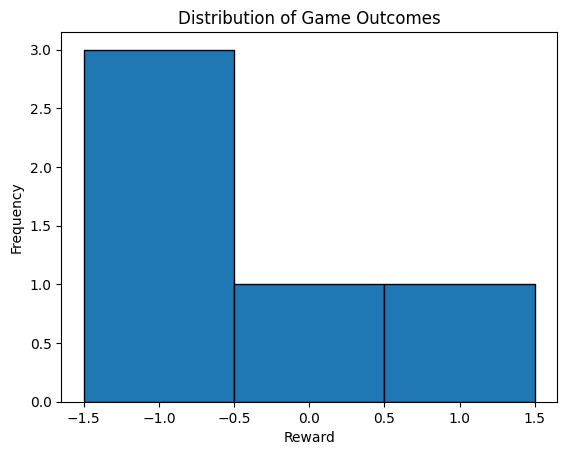

Episode 500/5000
Episode 1000/5000
Episode 1500/5000
Episode 2000/5000
Episode 2500/5000
Episode 3000/5000
Episode 3500/5000
Episode 4000/5000
Episode 4500/5000
Episode 5000/5000
Action-value function estimated.
Episode 500/10000
Episode 1000/10000
Episode 1500/10000
Episode 2000/10000
Episode 2500/10000
Episode 3000/10000
Episode 3500/10000
Episode 4000/10000
Episode 4500/10000
Episode 5000/10000
Episode 5500/10000
Episode 6000/10000
Episode 6500/10000
Episode 7000/10000
Episode 7500/10000
Episode 8000/10000
Episode 8500/10000
Episode 9000/10000
Episode 9500/10000
Episode 10000/10000
Optimal policy obtained.


In [10]:
#play 5 games using the custom policy
results = play_blackjack(env, custom_policy, games=5)

#analyse the game results
analyse_results(results)

#estimate Q using monte carlo prediction
Q = monte_carlo_prediction(env, custom_policy, episodes=5000)
print('Action-value function estimated.')

#find optimal policy using monte carlo control
optimal_policy, optimal_Q = monte_carlo_control(env, episodes=10000, alpha=0.1)
print('Optimal policy obtained.')
